# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
data = pd.read_csv(r'C:\Users\Oleg\Desktop\nlp\train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [6]:
data.isnull().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [7]:
data.fillna('', inplace = True)

In [8]:
data.isnull().any()

id          False
keyword     False
location    False
text        False
target      False
dtype: bool

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [10]:
class_distribution = train['target'].value_counts()
class_distribution

0    3024
1    2305
Name: target, dtype: int64

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [11]:
word_freq = data['keyword'].value_counts()
word_freq

                         61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

In [12]:
word_freq.drop("", axis=0, inplace=True)
word_freq

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [13]:
popular_keywords = word_freq.head(10).index.tolist()
popular_keywords

['fatalities',
 'deluge',
 'armageddon',
 'sinking',
 'damage',
 'harm',
 'body%20bags',
 'evacuate',
 'fear',
 'outbreak']

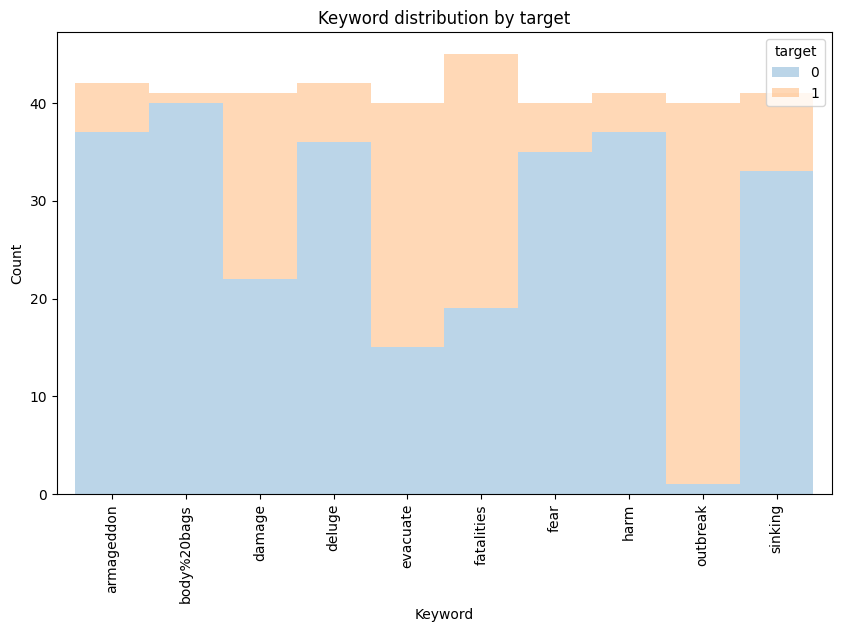

In [14]:
data_filtered = data[data['keyword'].isin(popular_keywords)]

# Считаем количество упоминаний каждого слова в target==1 и target==0
keyword_count = data_filtered.groupby(['keyword', 'target']).size().unstack(fill_value=0)

# Создаем ступенчатую диаграмму
fig, ax = plt.subplots(figsize=(10, 6))
keyword_count.plot(kind='bar', stacked=True, alpha=0.3, width=1.0, ax=ax)

plt.title('Keyword distribution by target')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.show()

**Выводы**: Слова из 10 самых встречающихся чаще принадлежат классу "1" (в сообщении содержится информации о реальной опасности)

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [15]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [16]:
train['text'] = train[['keyword', 'location', 'text']].agg(' '. join , axis= 1)

In [17]:
train_new = train.drop(columns = ['id', 'keyword', 'location'])

In [18]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


In [57]:
test['text'] = test[['keyword', 'location', 'text']].agg(' '. join , axis= 1)
test_new = test.drop(columns = ['id', 'keyword', 'location'])

## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [19]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [20]:
text_counts = vectorizer.fit_transform(train_new['text'])
text_counts.shape

(5329, 18455)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [21]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    return any(map(str.isdigit, s))

def contains_punctuation(s: str) -> bool:
    for i in s:
        if i in punctuation:
            return True
    return False
    

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    for i in s:
        if i == "#":
            return True
    return False
    

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    for i in s:
        if i == "@":
            return True
    return False

def investigate_vocabulary(vocabulary):
    digits = 0
    punctuations = 0
    hashtags = 0
    mentions = 0
    for s, i in vocabulary.items():
        if contains_digit(s):
            digits+=1
        if contains_punctuation(s):
            punctuations+=1
        if is_hashtag(s):
            hashtags+=1
        if is_mention(s):
            mentions+=1
    print('With digit:      ', digits
          )
    print('With punctuation:', punctuations
          )
    print('Hashtags:        ', hashtags
          )
    print('Mentions:        ', mentions
          )

In [22]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}

In [23]:
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [24]:
investigate_vocabulary(vectorizer.vocabulary_)

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [25]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [26]:
tweet_tokenizer = TweetTokenizer()

In [30]:
def tokenize_tweet(text):
    return tweet_tokenizer.tokenize(text)

In [31]:
vectorizer = CountVectorizer(tokenizer=tokenize_tweet)
text_counts_tt = vectorizer.fit_transform(train_new['text'])
text_counts_tt.shape

C:\Users\Oleg\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5329, 19670)

In [32]:
investigate_vocabulary(vectorizer.vocabulary_)

With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1685


**Сравнение:** Без применения фильтрации от TweetTokenizer векторайзер не берет во внимания слова с хештегами и упоминаниями, более того, пропускает много слов с пунктуацией, так же пропускает несколько слов с числами, с применением TweetTokenizer все встало на свои места.

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [48]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
from typing import List
import string

def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return all(char in string.ascii_letters for char in s)

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    return all(char in string.punctuation or char in string.ascii_letters for char in s)

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s.startswith('#') and all(char in string.ascii_letters for char in s[1:])

def custom_tokenizer(s: str) -> List[str]:
    # Приведение всех букв к нижнему регистру
    s = s.lower()

    # Инициализация TweetTokenizer
    tweet_tokenizer = TweetTokenizer()

    # Разбиение текста на токены с помощью TweetTokenizer
    tokens = tweet_tokenizer.tokenize(s)

    # Удаление токенов, содержащих не латинские буквы, за исключением смайликов и хэштегов
    tokens = [token for token in tokens if contains_only_latin_letters(token) or is_emoji(token) or is_hashtag(token)]

    # Удаление стоп-слов из списка токенов
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Применение стемминга с помощью SnowballStemmer
    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Oleg\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [49]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [54]:
for index, row in train_new.head(10).iterrows():
    text = row['text']
    tokens = custom_tokenizer(text)
    print(tokens)

['bridg', '%', 'ash', ':', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', ':', 'england', 'bundl', 'australia', '...']
['hail', 'carol', 'stream', ',', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '@hail_youtsey', '.', '#goblu', '#wrestleon']
['polic', 'houston', 'cnn', ':', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class', '.']
['wound', 'lake', 'highland', 'crack', 'path', 'wipe', 'morn', 'beach', 'run', '.', 'surfac', 'wound', 'left', 'elbow', 'right', 'knee', '.', 'http://t.co/yaqrsximph']
['airplan', '%', 'somewher', 'expert', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'reunion', 'island', ':', 'french', 'air', 'accid', 'expert', '...', '#mlb']
['bloodi', 'isol', 'citi', 'world', 'perth', "'", 'came', 'kill', 'indian', '...', 'fun', "'", ':', 'video', 'smirk', 'remorseless', 'pakistani', 'killer', 'show', 'boast', '.', 'http://t.co/fpjlwoxklg']
['burn

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [58]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
X_train = vectorizer.fit_transform(train_new['text'])
X_test = vectorizer.transform(test_new['text'])

C:\Users\Oleg\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [60]:
y_train = train_new['target']
y_test = test_new['target']

2. Обучите LogisticRegression на полученных признаках.


In [67]:
from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression(random_state=1)
LogReg.fit(X_train, y_train)

C:\Users\Oleg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1)

3. Посчитайте метрику f1-score на тестовых данных.

In [64]:
from sklearn.metrics import f1_score
y_pred = LogReg.predict(X_test)
F1 = f1_score(y_test, y_pred)
print('F1 score:', F1)

F1 score: 0.7512090274046211


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [161]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
X_train_tfidf = vectorizer.fit_transform(train_new['text'])
X_test_tfidf = vectorizer.transform(test_new['text'])

C:\Users\Oleg\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [162]:
LogReg = LogisticRegression(random_state=3)
LogReg.fit(X_train_tfidf, y_train)

LogisticRegression(random_state=3)

In [163]:
y_pred = LogReg.predict(X_test_tfidf)
F1 = f1_score(y_test, y_pred)
print('F1 score:', F1)

F1 score: 0.7414364640883977


1. **Ответ:** качество испытало отрицательный рост

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [188]:
# 2
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)
X_train_tfidf = vectorizer.fit_transform(train_new['text'])
X_test_tfidf = vectorizer.transform(test_new['text'])

C:\Users\Oleg\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [189]:
LogReg = LogisticRegression(random_state=3)
LogReg.fit(X_train_tfidf, y_train)

LogisticRegression(random_state=3)

In [190]:
y_pred = LogReg.predict(X_test_tfidf)
F1 = f1_score(y_test, y_pred)
print('F1 score:', F1)

F1 score: 0.7414364640883977


2. **Ответ:** качество не изменилось, что может говорить нам о том, что нет слов, которые встречались бы чаще чем 90% случаев (я поэксперементировал, оказалось, что какие либо измения начнутся только при макс дф = 0.3)

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [173]:
# 3
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9, min_df=0.005)
X_train_tfidf = vectorizer.fit_transform(train_new['text'])
X_test_tfidf = vectorizer.transform(test_new['text'])

C:\Users\Oleg\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [174]:
LogReg = LogisticRegression(random_state=3)
LogReg.fit(X_train_tfidf, y_train)

LogisticRegression(random_state=3)

In [175]:
y_pred = LogReg.predict(X_test_tfidf)
F1 = f1_score(y_test, y_pred)
print('F1 score:', F1)

F1 score: 0.7140513942044834


3. **Ответ:** улучшения качества не удалось добиться, эксперементировал с разными значениями, но каждый раз качество только ухудшалось

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [202]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5000)
X_train_hv = vectorizer.fit_transform(train_new['text'])
X_test_hv = vectorizer.transform(test_new['text'])

C:\Users\Oleg\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [203]:
LogReg = LogisticRegression(random_state=3)
LogReg.fit(X_train_hv, y_train)

LogisticRegression(random_state=3)

In [204]:
y_pred = LogReg.predict(X_test_hv)
F1 = f1_score(y_test, y_pred)
print('F1 score:', F1)

F1 score: 0.7157190635451506


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** самым эффективным оказался CountVectorizer, показав результат в 0.7512090274046211

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [205]:
# Добился 0.75 еще в задании 8.
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
X_train = vectorizer.fit_transform(train_new['text'])
X_test = vectorizer.transform(test_new['text'])

C:\Users\Oleg\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [208]:
LogReg = LogisticRegression(random_state=1)
LogReg.fit(X_train, y_train)

C:\Users\Oleg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1)

In [209]:
y_pred = LogReg.predict(X_test)
F1 = f1_score(y_test, y_pred)
print('F1 score:', F1)

F1 score: 0.7512090274046211
